In [9]:
import sys

sys.path.insert(0, "../")

import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from src_code.task_utils.config_parser import ConfigParser
from src_code.data_utils.dataset_utils import CaptchaDataset, get_dataloader
from src_code.data_utils.preprocessing import get_img_transform, get_rectangle_img_transform
from src_code.model_utils.mnist_ssd import SSD, BaseConv, pretty_print_module_list, AuxConv
import src_code.model_utils.utils_mnist_ssd as utils_mnist_ssd
from src_code.model_utils.mnist_ssd import SSD
from torch import nn
import yaml
from torchvision.utils import draw_bounding_boxes
from src_code.task_utils.evaluation import edit_score
import json
import os


### Load Config Files

In [10]:

# Load the base config
base_config_path = "../configs/configs_common_notebook.yaml"
if not Path(base_config_path).exists():
    raise FileNotFoundError(f"Base config file not found: {base_config_path}")

with open(base_config_path, "r") as file:
    base_config_dict = yaml.safe_load(file)

configs = ConfigParser(base_config_dict).get_parser()

# Load the SSD-specific config
ssd_config_path = "../configs/default_ssd_configs.yaml"
if not Path(ssd_config_path).exists():
    raise FileNotFoundError(f"SSD config file not found: {ssd_config_path}")

with open(ssd_config_path, "r") as file:
    ssd_config_dict = yaml.safe_load(file)

configs.update(ssd_config_dict)

config = {'task': 'train', 'data_configs': {'train_path': 'datasets/utn_dataset_curated/part2/train', 'val_path': 'datasets/utn_dataset_curated/part2/val', 'test_path': 'datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'color': False, 'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'train_preprocessed_dir': '../datasets/utn_dataset_curated/part2/train/images', 'val_preprocessed_dir': '../datasets/utn_dataset_curated/part2/val/images', 'test_preprocessed_dir': '../datasets/utn_dataset_curated/part2/test/images', 'train_labels_dir': '../datasets/utn_dataset_curated/part2/train/labels', 'val_labels_dir': '../datasets/utn_dataset_curated/part2/val/labels', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0.5, 'zoom_prob': 0.3, 'rotation_prob': 0.2, 'line_prob': 0.1, 'salt_pepper_prob': 0.2}}, 'model_configs': {'name': 'ssd_mnist', 'save_checkpoint': True, 'log_gradients': False, 'checkpoint': None, 'print_freq': 500, 'epochs'

### Load Test Dataset

In [11]:

test_dataset = CaptchaDataset(
    configs.test_preprocessed_dir,
    labels_dir=None,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)

print(test_dataset)

Dataset CaptchaDataset
    Number of datapoints: 20000
    Root location: ../datasets/utn_dataset_curated/part2/test/images


In [12]:
val_dataset = CaptchaDataset(
    configs.val_preprocessed_dir,
    labels_dir=configs.val_labels_dir,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)

print(val_dataset)

Dataset CaptchaDataset
    Number of datapoints: 20000
    Root location: ../datasets/utn_dataset_curated/part2/val/images


In [13]:
train_dataset = CaptchaDataset(
    configs.train_preprocessed_dir,
    labels_dir=configs.train_labels_dir,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)

print(train_dataset)

Dataset CaptchaDataset
    Number of datapoints: 60000
    Root location: ../datasets/utn_dataset_curated/part2/train/images


Load DataLoader

In [14]:
val_loader = get_dataloader(val_dataset, configs)
train_loader = get_dataloader(train_dataset, configs)
test_loader = get_dataloader(test_dataset, configs)

### Load Model

In [15]:
base_conv = BaseConv(configs.base_conv_conv_layers, 
                    configs.base_conv_input_size, chosen_fm=[-2, -1],
                    norm=nn.BatchNorm2d, act_fn=nn.ReLU(), spectral=False).to(configs.device)

In [18]:
new_h = configs.img_height // configs.downscale_factor
new_w = configs.img_width // configs.downscale_factor
setattr(configs, "base_conv_input_size", [new_h, new_w])
test_img = torch.zeros([1,1,configs.base_conv_input_size[0], configs.base_conv_input_size[1]]).to(configs.device)
base_size = pretty_print_module_list(base_conv.module_list, test_img)

aux_conv = AuxConv(configs.aux_conv_conv_layers, 
                configs.aux_conv_input_size, norm=nn.BatchNorm2d, act_fn=nn.ReLU(), spectral=False)
aux_size = pretty_print_module_list(aux_conv.module_list, torch.zeros(base_size[-1]))

setattr(configs, 'fm_channels', [base_size[i][1] for i in base_conv.fm_id] + [aux_size[i][1] for i in aux_conv.fm_id])
setattr(configs, 'fm_size', [base_size[i][-2:] for i in base_conv.fm_id] + [aux_size[i][-2:] for i in aux_conv.fm_id])
setattr(configs, 'n_fm', len(configs.fm_channels))
setattr(configs,'fm_prior_aspect_ratio', configs.fm_prior_aspect_ratio[:configs.n_fm])
setattr(configs,'fm_prior_scale', np.linspace(0.1, 0.9, configs.n_fm)) #[0.2, 0.375, 0.55, 0.725, 0.9] # [0.1, 0.2, 0.375, 0.55, 0.725, 0.9] 
assert len(configs.fm_prior_scale) == len(configs.fm_prior_aspect_ratio)
setattr(configs, 'n_prior_per_pixel', [len(i)+1 for i in configs.fm_prior_aspect_ratio]) #in fm1, each pixel has 4 priors
setattr(configs, 'multistep_milestones', list(range(10, configs.epochs, 5)))
utils_mnist_ssd.img_size = base_size[0][-1]

model = SSD(configs, base_conv, aux_conv).to(configs.device)

checkpoint = torch.load("../docs_and_results/demo/model_checkpoint.pth", weights_only=False, map_location=configs.device)
print(checkpoint)
# Load model state
model.load_state_dict(checkpoint["model_state"])
model = model.to(configs.device)
model.eval()

There are 12780 priors in this model
Done initialization
{'epoch': 10, 'model_state': OrderedDict([('base_conv.module_list.0.conv.weight', tensor([[[[ 0.2293,  0.0975,  0.0671],
          [-0.1477, -0.3350,  0.0729],
          [ 0.0607, -0.2338,  0.1689]]],


        [[[-0.1583,  0.2402, -0.0808],
          [-0.3484,  0.2839,  0.1248],
          [-0.1505,  0.0365,  0.0696]]],


        [[[ 0.1736,  0.2496, -0.5329],
          [-0.0540, -0.0262,  0.2001],
          [-0.0787,  0.0633, -0.0237]]],


        [[[-0.0391, -0.1331,  0.0337],
          [ 0.2415,  0.1272, -0.1388],
          [ 0.3469,  0.0776, -0.3863]]],


        [[[-0.0535,  0.2960,  0.1645],
          [-0.1554, -0.3218, -0.0531],
          [ 0.1746,  0.0252, -0.0515]]],


        [[[ 0.1474, -0.1020, -0.0681],
          [ 0.0931, -0.1623, -0.1328],
          [ 0.0958, -0.0435, -0.1355]]],


        [[[ 0.0096, -0.0810, -0.2594],
          [ 0.2769, -0.1018, -0.2929],
          [ 0.1994,  0.1669,  0.0653]]],


        [[[-0.

SSD(
  (base_conv): BaseConv(
    (module_list): ModuleList(
      (0): Conv(
        (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

### Generate and Save for Submission Function

In [19]:
img, gt_truth, labels = next(iter(val_loader))

In [20]:
# For Val Dataset

def val_generate_captchas_submission(model, val_loader, configs, output_file: str = "val_captchas_submission.json"):
    """
    Generates captchas for the set using the pre-loaded model and saves the results in a JSON file.
    """
    results = {}
    with torch.no_grad():
        for images, gt_truth, labels_gt in val_loader:
            # print(img, gt_truth, labels)
            images = images.to(configs.device)
            for idx, image in enumerate(images):
                # print(image.unsqueeze(0))
                loc_preds, cls_preds, _ = model(image.unsqueeze(0))
                boxes, labels, scores = model.detect_object(loc_preds, cls_preds, min_score=0.25, max_overlap=0.5,top_k=20)
                
                list_boxes = boxes[0].tolist()
                assert len(list_boxes) == len(labels[0])
                for i, label_idx in enumerate(labels[0].tolist()):
                    list_boxes[i].append(label_idx)
                list_boxes = sorted(list_boxes, key=lambda x: x[0])
                predicted_captcha = "".join([configs.category_id_labels[i[-1]] for i in list_boxes])
                gt_string = "".join([configs.category_id_labels[i] for i in labels_gt[idx].tolist()])
                print(f"{gt_string = }", f"{predicted_captcha = }")

val_generate_captchas_submission(model, val_loader, configs, output_file = "val_captchas_submission.json")

/Users/lucaheller/Desktop/UTN_Captcha_Detector/notebooks/../src_code/model_utils/mnist_ssd.py:295: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(decoded_locs[above_min_score_index][sorted_index][keep])
/Users/lucaheller/Desktop/UTN_Captcha_Detector/notebooks/../src_code/model_utils/mnist_ssd.py:297: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(sorted_score[keep])


gt_string = 'CKG2' predicted_captcha = 'C3KG2'
gt_string = 'M28D5G' predicted_captcha = 'M2B85G'
gt_string = '6H' predicted_captcha = '6H'
gt_string = 'BFK' predicted_captcha = 'BFK'
gt_string = 'Q3AR' predicted_captcha = '0Q3SA4R'
gt_string = 'AT04' predicted_captcha = 'AT04'
gt_string = '08' predicted_captcha = '08'
gt_string = '0SE' predicted_captcha = '0SE'
gt_string = 'T61' predicted_captcha = 'T61'
gt_string = 'LA0J1G' predicted_captcha = '6AR0L1IG'
gt_string = '4J' predicted_captcha = '4JI'
gt_string = 'UEHD61' predicted_captcha = 'HEHQD61I'
gt_string = 'PR3O' predicted_captcha = 'R3O'
gt_string = 'Z71E' predicted_captcha = 'Z71E'
gt_string = '4EDD29' predicted_captcha = 'E0D29'
gt_string = 'MH' predicted_captcha = 'MH'
gt_string = 'F8M0F2' predicted_captcha = 'F980F2'
gt_string = 'D0WFHU' predicted_captcha = '00WHFHU'
gt_string = 'YXX' predicted_captcha = 'YXX'
gt_string = 'K1R' predicted_captcha = 'KX179'
gt_string = '1BM81N' predicted_captcha = 'IB4MIH'
gt_string = '0I8U' pre

In [21]:
img, gt_truth, labels = next(iter(train_loader))

In [22]:
# For Train Dataset

def train_generate_captchas_submission(model, train_loader, configs, output_file: str = "train_captchas_submission.json"):
    """
    Generates captchas for the set using the pre-loaded model and saves the results in a JSON file.
    """
    results = {}
    with torch.no_grad():
        for images, gt_truth, labels_gt in train_loader:
            # print(img, gt_truth, labels)
            images = images.to(configs.device)
            for idx, image in enumerate(images):
                # print(image.unsqueeze(0))
                loc_preds, cls_preds, _ = model(image.unsqueeze(0))
                boxes, labels, scores = model.detect_object(loc_preds, cls_preds, min_score=0.25, max_overlap=0.5,top_k=20)
                
                list_boxes = boxes[0].tolist()
                assert len(list_boxes) == len(labels[0])
                for i, label_idx in enumerate(labels[0].tolist()):
                    list_boxes[i].append(label_idx)
                list_boxes = sorted(list_boxes, key=lambda x: x[0])
                predicted_captcha = "".join([configs.category_id_labels[i[-1]] for i in list_boxes])
                gt_string = "".join([configs.category_id_labels[i] for i in labels_gt[idx].tolist()])
                # print(f"{gt_string = }", f"{predicted_captcha = }")

train_generate_captchas_submission(model, train_loader, configs, output_file = "train_captchas_submission.json")

In [23]:
img = next(iter(test_loader))

In [24]:
# For Test Data

def test_generate_captchas_submission(model, test_loader, configs, test_path, output_file: str = "test_captchas_submission.json"):
    """
    Generates captchas for the test set using the pre-loaded model and saves the results in a JSON file.
    """
    results = []

    # Get sorted list fo filenames
    filenames = sorted([f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))])

    with torch.no_grad():
        for batch_idx, images in enumerate(test_loader):  # No image_paths
            images = images.to(configs.device)

            for idx, image in enumerate(images):
                img_index = batch_idx * len(images) + idx

                if batch_idx * len(images) + idx < len(filenames):
                    filename = filenames[img_index]
                    image_id = os.path.splitext(filename)[0]  # Remove extension
                else:
                    print(f"Warning: Missing filename for batch {batch_idx}, index {idx}")
                    continue

                # If image is 2D (H, W), add a channel dimension
                if image.dim() == 2:
                    image = image.unsqueeze(0)  # Make it (1, H, W)

                # If image is 3D (C, H, W), add batch dimension
                if image.dim() == 3:
                    image = image.unsqueeze(0)  # Make it (1, C, H, W)

                # Forward pass
                loc_preds, cls_preds, _ = model(image)
                boxes, labels, scores = model.detect_object(loc_preds, cls_preds, min_score=0.25, max_overlap=0.5, top_k=20)

                list_boxes = boxes[0].tolist()
                assert len(list_boxes) == len(labels[0])

                for i, label_idx in enumerate(labels[0].tolist()):
                    list_boxes[i].append(label_idx)

                list_boxes = sorted(list_boxes, key=lambda x: x[0])
                predicted_captcha = "".join([configs.category_id_labels[i[-1]] for i in list_boxes])

                results.append({
                    "image_id": image_id,
                    "captcha_string": predicted_captcha
                })

    # Save results to JSON
    with open(output_file, "w") as f:
        json.dump(results, f, indent=4)

    print(f"Predictions saved to {output_file}")

test_generate_captchas_submission(model, test_loader, configs, test_path = "../datasets/utn_dataset_curated/part2/test/images", output_file = "part2_preds.json")

Predictions saved to part2_preds.json


In [ ]:
import os
import torch
import json

def test_generate_captchas_submission(model, test_loader, configs, test_path, output_file="test_captchas_submission.json"):
    """
    Generates captchas for the test set using the pre-loaded model and saves the results in a JSON file.
    Image IDs are now taken directly from the filename (without the file extension).
    """
    results = []

    # Ensure filenames are sorted numerically
    filenames = sorted(
        [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))],
        key=lambda x: int(os.path.splitext(x)[0])  # Sort based on numeric value
    )

    with torch.no_grad():
        for batch_idx, images in enumerate(test_loader):
            images = images.to(configs.device)

            for idx, image in enumerate(images):
                # Stop if there are no more filenames left
                if idx + batch_idx * len(images) >= len(filenames):
                    print(f"All images processed up to index {idx + batch_idx * len(images)}. Stopping.")
                    break

                filename = filenames[idx + batch_idx * len(images)]  # Get file based on current index
                file_number = os.path.splitext(filename)[0]  # Extract number without file extension
                image_id = file_number  # Use file number as image_id

                # print(f"Processing: {file_number} → Image ID: {image_id}")  # Debugging output

                # Ensure image has correct dimensions
                if image.dim() == 2:
                    image = image.unsqueeze(0)  # Convert to (1, H, W)
                if image.dim() == 3:
                    image = image.unsqueeze(0)  # Convert to (1, C, H, W)

                # Forward pass through model
                loc_preds, cls_preds, _ = model(image)
                boxes, labels, scores = model.detect_object(
                    loc_preds, cls_preds, min_score=0.15, max_overlap=0.5, top_k=20
                )

                list_boxes = boxes[0].tolist()
                
                if len(list_boxes) == 0:
                    print(f"⚠ Warning: No predictions for {image_id}, skipping.")
                    continue  # Skip images with no predictions

                assert len(list_boxes) == len(labels[0])

                # Append label to box data
                for i, label_idx in enumerate(labels[0].tolist()):
                    list_boxes[i].append(label_idx)

                # Sort boxes left-to-right
                list_boxes = sorted(list_boxes, key=lambda x: x[0])

                # Convert labels to string
                predicted_captcha = "".join([configs.category_id_labels[i[-1]] for i in list_boxes])

                results.append({
                    "image_id": image_id,  # Now using the file number directly
                    "captcha_string": predicted_captcha
                })

    # Debugging output to verify all images are included
    print(f"📌 Processed images: {[r['image_id'] for r in results]}")
    assert len(results) == len(filenames), "⚠ Not all images were processed!"

    # Save results to JSON
    with open(output_file, "w") as f:
        json.dump(results, f, indent=4)

    print(f"Predictions saved to {output_file}")


test_generate_captchas_submission(model, test_loader, configs, test_path = "../datasets/utn_dataset/part3/test/images", output_file = "part3_preds.json")

Predictions saved to part3_preds.json


In [32]:
test_generate_captchas_submission(
    model, 
    test_loader, 
    configs, 
    test_path="../datasets/utn_dataset_curated/part4/test/images", 
    output_file="part4_preds.json"
)


Predictions saved to part4_preds.json


### Get predictions

In [33]:

# Sample image
image = test_dataset[0]
image = image.unsqueeze(0).to(configs.device)
print(image.shape)
# Model prediction
with torch.no_grad():
    loc_preds, cls_preds, _ = model(image)
    boxes, labels, scores = model.detect_object(loc_preds, cls_preds, min_score=0.25, max_overlap=0.5,top_k=20)


torch.Size([1, 1, 40, 160])


/Users/lucaheller/Desktop/UTN_Captcha_Detector/notebooks/../src_code/model_utils/mnist_ssd.py:295: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(decoded_locs[above_min_score_index][sorted_index][keep])
/Users/lucaheller/Desktop/UTN_Captcha_Detector/notebooks/../src_code/model_utils/mnist_ssd.py:297: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(sorted_score[keep])


### Plot Sample Image

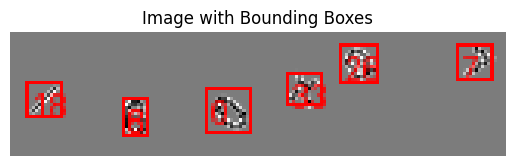

In [34]:
# Convert Labels

#labels = [category_id_labels[label.item()] for label in labels[0]]

def plot_image_with_bboxes(image, bboxes, labels, title="Image with Bounding Boxes"):
    img_height, img_width = image.shape[1], image.shape[2] 
    
    # Scale normalized bboxes to absolute pixel values for visualization
    bboxes[:, [0, 2]] *= img_width
    bboxes[:, [1, 3]] *= img_height

    # Convert to integer values for plotting
    bboxes_abs = bboxes.to(torch.int)

    # Ensure labels are strings
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    labels = [str(l) for l in labels]

    # Draw bounding boxes
    image_with_boxes = draw_bounding_boxes(image, bboxes_abs, labels=labels, colors="red", width=1)

    # Image tensor to NumPy for visualization
    img = image_with_boxes.permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


plot_image_with_bboxes(image.squeeze(0), boxes[0], labels[0])

In [35]:
from src_code.model_utils.train_utils import generate_edit_distance

edit_distances = generate_edit_distance(model, val_loader, configs)
print("Edit Distances:", edit_distances)


ImportError: cannot import name 'generate_edit_distance' from 'src_code.model_utils.train_utils' (/Users/lucaheller/Desktop/UTN_Captcha_Detector/notebooks/../src_code/model_utils/train_utils.py)